# Mojito noise pipeline with the inclusion of gaps

Very simple L01 pipeline, containing
* reading of the data (telemetry, ground tracking, and instrument knowledge)
* optionally correction for group delays
* directly use the PRN measurements as MPRs, and compute a 2-point difference
  for the MPR derivatives
* calculation of intermediary and Michelson TDI variables with gaps treated as nans.

This pipeline uses data saved in adjacent HDF5 files, saved on Git LFS. To
re-generate the data, use the adjacent `simulation.ipynb` notebook.

In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import yaml
import logging
import numpy as np
import matplotlib.pyplot as plt
import h5py

from lolipops.conventions import MOSAS
from lolipops.pipelines import welch, tdi_secondaries
from lolipops.constellation.tdi import (
    compute_factorized_intervars,
    compute_factorized_michelson,
    compute_unfactorized_michelson,
    trim_tdis,
)
from lolipops.local import ifo, prn

from lolipops.io import read_telemetry_from_instrument, read_ground_tracking, Sampling

logging.basicConfig(level=logging.INFO)
logging.getLogger("pytdi").setLevel(logging.WARNING)

from LISA_artefacts import GapMaskGenerator

## Read data

In [ ]:
telemetry_file = "data/simple/instru.h5"
ground_tracking_file = "data/simple/groundtrack.h5"

telemetry, instrument_knowledge = read_telemetry_from_instrument(telemetry_file)
ground_tracking = read_ground_tracking(ground_tracking_file, telemetry_file)

orbits_file = "data/simple/orbits.h5"

In [ ]:
# Configuration file
config_file = "data/simple/config.yaml"

with Path(config_file).open("r") as file:
    config_dict = yaml.safe_load(file)

## IFO control plots

In [ ]:
# Telemetry data and apply group delay corrections
ifos = telemetry.ifos
prns = telemetry.prns

# Group delay correction
corrected_ifos = ifo.cancel_filter_group_delay(
    ifos, telemetry.sampling, telemetry.instrument_knowledge
)
corrected_prns = prn.cancel_filter_group_delay(
    prns, telemetry.sampling, telemetry.instrument_knowledge
)

# Time
t = telemetry.sampling.t()

In [ ]:
# IFO measurements control plots - time domain

STOP = -1
STEP = 100

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].plot(t[:STOP:STEP], ifos[f"isi_{mosa}"][:STOP:STEP], label=mosa)
    axs[1].plot(t[:STOP:STEP], corrected_ifos[f"isi_{mosa}"][:STOP:STEP], label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Beatnote [Hz]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Time [s]")
axs[1].set_title("After group delay correction")
fig.suptitle("ISI Carrier Beatnotes")
plt.show()

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].plot(t[:STOP:STEP], ifos[f"tmi_{mosa}"][:STOP:STEP], label=mosa)
    axs[1].plot(t[:STOP:STEP], corrected_ifos[f"tmi_{mosa}"][:STOP:STEP], label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Beatnote [Hz]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Time [s]")
axs[1].set_title("After group delay correction")
fig.suptitle("TMI Carrier Beatnotes")
plt.show()

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].plot(t[:STOP:STEP], ifos[f"rfi_{mosa}"][:STOP:STEP], label=mosa)
    axs[1].plot(t[:STOP:STEP], corrected_ifos[f"rfi_{mosa}"][:STOP:STEP], label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("Beatnote [Hz]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Time [s]")
axs[1].set_title("After group delay correction")
fig.suptitle("RFI Carrier Beatnotes")
plt.show()

In [ ]:
# IFO measurements control plots - spectral estimate

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].loglog(*welch(ifos[f"isi_{mosa}"], telemetry.sampling), label=mosa)
    axs[1].loglog(*welch(corrected_ifos[f"isi_{mosa}"], telemetry.sampling), label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_ylabel("ASD [Hz/sqrt(Hz)]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_title("After group delay correction")
fig.suptitle("ISI Carrier Beatnotes")
plt.show()

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].loglog(*welch(ifos[f"tmi_{mosa}"], telemetry.sampling), label=mosa)
    axs[1].loglog(*welch(corrected_ifos[f"tmi_{mosa}"], telemetry.sampling), label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_ylabel("ASD [Hz/sqrt(Hz)]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_title("After group delay correction")
fig.suptitle("TMI Carrier Beatnotes")
plt.show()

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].loglog(*welch(ifos[f"rfi_{mosa}"], telemetry.sampling), label=mosa)
    axs[1].loglog(*welch(corrected_ifos[f"rfi_{mosa}"], telemetry.sampling), label=mosa)
axs[0].legend(loc="upper right")
axs[0].set_xlabel("Frequency [Hz]")
axs[0].set_ylabel("ASD [Hz/sqrt(Hz)]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="upper right")
axs[1].set_xlabel("Frequency [Hz]")
axs[1].set_title("After group delay correction")
fig.suptitle("RFI Carrier Beatnotes")
plt.show()

In [ ]:
# PRN control plot

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    axs[0].plot(t[:STOP:STEP], prns[mosa][:STOP:STEP], label=mosa)
    axs[1].plot(t[:STOP:STEP], corrected_prns[mosa][:STOP:STEP], label=mosa)
axs[0].legend(loc="center right")
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel("PRN [s]")
axs[0].set_title("Before group delay correction")
axs[1].legend(loc="center right")
axs[1].set_xlabel("Time [s]")
axs[1].set_title("After group delay correction")
fig.suptitle("PRN Carrier Beatnotes")
plt.show()

## MPR control plots

In [ ]:
mprs = corrected_prns

mpr_derivatives = {
    mosa: np.gradient(mprs[mosa], telemetry.sampling.dt) for mosa in MOSAS
}

In [ ]:
with h5py.File(orbits_file, "r") as f:
    true_t = f.attrs["t0"] + np.arange(f.attrs["size"]) * f.attrs["dt"]
    true_ltts = f["tcb/ltt"][:]
    true_ltt_derivatives = f["tcb/d_ltt"][:]

# Restrict true_t to the telemetry time range
start_index = np.where(true_t >= t[0])[0][0] - 1
end_index = np.where(true_t <= t[-1])[0][-1] + 2
true_t = true_t[start_index:end_index]
true_ltts = true_ltts[start_index:end_index]
true_ltt_derivatives = true_ltt_derivatives[start_index:end_index]

In [ ]:
plt.figure(figsize=(8, 5))
colors = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
for i, mosa in enumerate(MOSAS):
    color = next(colors)
    plt.plot(t[:STOP:STEP], mprs[mosa][:STOP:STEP], c=color, label=f"{mosa} (estim.)")
    plt.plot(true_t, true_ltts[:, i], "o", c=color, label=f"{mosa} (true)")
plt.legend(loc="upper right")
plt.xlabel("Time [s]")
plt.ylabel("MPR [s]")
plt.title("MPR Estimates")
plt.show()

plt.figure(figsize=(8, 5))
colors = iter(plt.rcParams["axes.prop_cycle"].by_key()["color"])
for i, mosa in enumerate(MOSAS):
    color = next(colors)
    plt.plot(
        t[:STOP:STEP],
        mpr_derivatives[mosa][:STOP:STEP],
        c=color,
        label=f"{mosa} (estim.)",
    )
    plt.plot(true_t, true_ltt_derivatives[:, i], "o", c=color, label=f"{mosa} (true)")
plt.legend(loc="upper right")
plt.xlabel("Time [s]")
plt.ylabel("MPR Derivative [s/s]")
plt.title("MPR Derivative Estimates")
plt.show()

# Build the gap function! 

Lost out on approximately 47.57694444444444 hours of data
This ammounts to 685108 number of samples


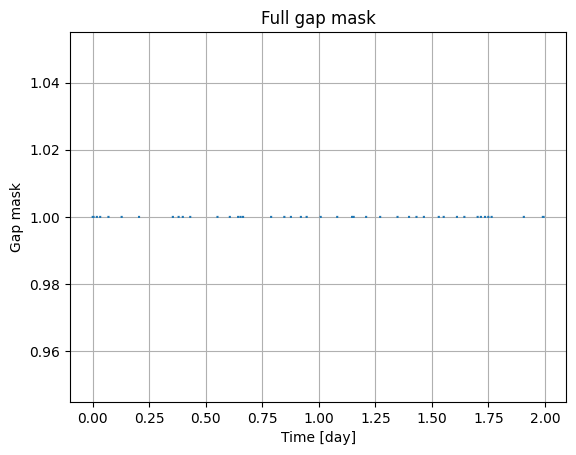

In [997]:
# Construct gap class

SINGLE_NAN = False
MULTIPLE_NANS = False
# from gap_mask_gekneration import GapMaskGenerator

N = telemetry.sampling.size
t_start = telemetry.sampling.t0

sim_t = np.arange(0, N * telemetry.sampling.dt, telemetry.sampling.dt)

gap_definitions = {
    "planned": {"Aliens": {"rate_per_year": 500, "duration_hr": 5}},
    "planned": {"Dinosaurs": {"rate_per_year": 100000, "duration_hr": 0.1}},
    "unplanned": {"None": {"rate_per_year": 0, "duration_hr": 0}},
}


# Initialise class with rates, and sampling properties.
generator = GapMaskGenerator(
    sim_t,
    telemetry.sampling.dt,
    gap_definitions,
    treat_as_nan=True,
    planseed=11_07_1993,
)

# Generate the mask full of gaps
full_mask = generator.generate_mask(include_unplanned=False, include_planned=True)

if SINGLE_NAN:
    mask_sing_nan = np.ones(len(full_mask))
    mid_index = int(len(mask_sing_nan) / 2)
    mask_sing_nan[mid_index] = np.nan
    masking_function = mask_sing_nan
if MULTIPLE_NANS:
    mask_mult_nan = np.ones(len(full_mask))
    mid_index = int(len(mask_mult_nan) / 2)
    mask_mult_nan[mid_index : mid_index + 20] = np.nan
    mask_mult_nan[mid_index + 40 : mid_index + 40 + 20] = np.nan
    # mask_mult_nan[mid_index + 150 : mid_index + 150 + 60] = np.nan
    masking_function = mask_mult_nan
else:
    masking_function = full_mask

plt.clf()

plt.plot(sim_t / 60 / 60 / 24, masking_function)
plt.title("Full gap mask")
plt.xlabel("Time [day]")
plt.ylabel("Gap mask")
plt.grid(True)

print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

Starting and ending indices of the gap in the telemetry data:
1354 688018


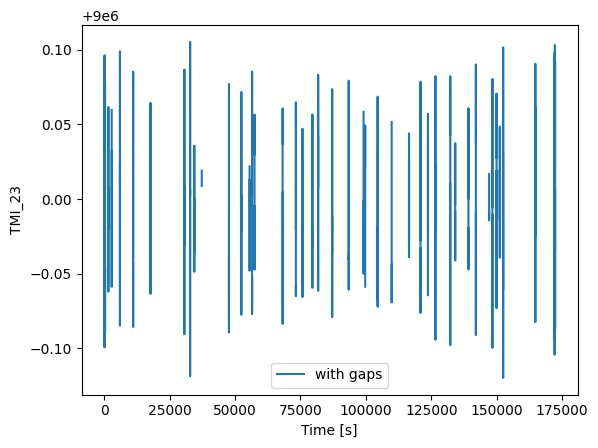

In [998]:
# Place the gaps in the telemetry variables
import copy

# Make a copy of the telemetric data variables
telemetry_w_gaps = copy.deepcopy(telemetry)

idx_start_gap = np.argwhere(np.isnan(masking_function) == True)[0][0]
idx_end_gap = np.argwhere(np.isnan(masking_function) == True)[-1][-1]


print("Starting and ending indices of the gap in the telemetry data:")
print(idx_start_gap, idx_end_gap)

tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
rfi_label = [f"rfi_{mosa}" for mosa in MOSAS]
rfi_usb_label = [f"rfi_usb_{mosa}" for mosa in MOSAS]
isi_label = [f"isi_{mosa}" for mosa in MOSAS]
isi_usb_label = [f"isi_usb_{mosa}" for mosa in MOSAS]

for tmi_item, rfi_item, rfi_usb_item, isi_item, isi_usb_item in zip(
    tmi_label, rfi_label, rfi_usb_label, isi_label, isi_usb_label
):
    telemetry_w_gaps.ifos[tmi_item] = (
        telemetry.ifos[tmi_item] * masking_function
    )  # No delays in each of these.
    telemetry_w_gaps.ifos[rfi_item] = (
        telemetry.ifos[rfi_item] * masking_function
    )  # No delays in each of these.
    telemetry_w_gaps.ifos[rfi_usb_item] = (
        telemetry.ifos[rfi_usb_item] * masking_function
    )  # No delays in each of these.
    telemetry_w_gaps.ifos[isi_item] = (
        telemetry.ifos[isi_item] * masking_function
    )  # No delays in each of these.
    telemetry_w_gaps.ifos[isi_usb_item] = (
        telemetry.ifos[isi_usb_item] * masking_function
    )  # No delays in each of these.

plt.clf()

# Plot
# plt.plot(sim_t, telemetry.ifos["tmi_23"], label="no gaps")
plt.plot(sim_t, telemetry_w_gaps.ifos["tmi_23"], label="with gaps", alpha=1)
# plt.xlim([sim_t[idx_start_gap]-100, sim_t[idx_end_gap]+100])
plt.ylabel(r"TMI_23")
plt.xlabel("Time [s]")
plt.legend()

In [956]:
mprs_w_nans = copy.deepcopy(mprs)
mpr_derivatives_w_nans = copy.deepcopy(mpr_derivatives)
for mosa in MOSAS:
    mprs_w_nans[mosa] = masking_function * mprs[mosa]
    mpr_derivatives_w_nans[mosa] = masking_function * mprs[mosa]

## TDIs, first compute intermediary variables without gaps, and with gaps treated as nans and zeros!

In [ ]:
etas = compute_factorized_intervars(
    telemetry.ifos, mprs, mpr_derivatives, telemetry.sampling, lagrange_interp_order=45
)

In [957]:
lagrange_order_eta_gap = 45
etas_w_gaps_nans = compute_factorized_intervars(
    telemetry_w_gaps.ifos,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    lagrange_interp_order=lagrange_order_eta_gap,
)
etas_w_gaps_zeros = {k: np.nan_to_num(v, nan=0.0) for k, v in etas_w_gaps_nans.items()}

INFO:lolipops.constellation.tdi:Computing factorized intermediary variables


In [ ]:
# Incorporate gaps into the Michelson like TDI variables using NaNs

lagrange_order_michelson_gap = 45
tdis_w_gaps_gen_1 = compute_factorized_michelson(
    etas_w_gaps_nans,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    generation=1,
    lagrange_interp_order=lagrange_order_michelson_gap,
)

lagrange_order_michelson_gap = 45
tdis_w_gaps_gen_2 = compute_factorized_michelson(
    etas_w_gaps_nans,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    generation=2,
    lagrange_interp_order=lagrange_order_michelson_gap,
)

INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables


INFO:lolipops.constellation.tdi:Trimming TDI combinations
INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Trimming TDI combinations


In [995]:
def merge_intervals(intervals):
    """Merge overlapping or adjacent intervals."""
    if not intervals:
        return []

    # Sort by start of interval
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]

    for current in intervals[1:]:
        prev = merged[-1]
        if current[0] <= prev[1] + 1:  # Overlapping or adjacent
            merged[-1] = (prev[0], max(prev[1], current[1]))
        else:
            merged.append(current)
    return merged

def compute_nan_indices_delay(object_w_nans, delay=33, order=45):
    """
    Generalized function to compute eta NaN indices due to multiple telemetry NaN gaps,
    with interval merging to avoid overlaps.
    """

    nan_indices = np.argwhere(np.isnan(object_w_nans)).flatten()
    N_original_series = len(object_w_nans)
    if nan_indices.size == 0:
        return np.array([], dtype=int)

    # Identify contiguous NaN segments
    nan_blocks = np.split(nan_indices, np.where(np.diff(nan_indices) > 1)[0] + 1)

    # Store all intervals affected
    affected_intervals = []

    p = int((order + 1) / 2)

    for block in nan_blocks:
        n_object_first = block[0]
        n_object_last = block[-1]

        # Direct NaNs
        direct_start = n_object_first
        direct_end = n_object_last

        # Delayed NaNs (inclusive)
        delay_start = n_object_first + delay - p + 1
        delay_end = n_object_last + delay - (1 - p) + 1

        affected_intervals.append((direct_start, direct_end))
        affected_intervals.append((delay_start, delay_end))

    # Merge overlapping/adjacent intervals
    merged_intervals = merge_intervals(affected_intervals)

    # Generate unique indices from merged intervals
    affected_indices = np.concatenate([
        np.arange(start, end + 1) for start, end in merged_intervals
    ])

    affected_indices = affected_indices[(affected_indices >= 0) & (affected_indices < N_original_series)]
    affected_indices = np.unique(affected_indices)

    # # Create eta mask array: 1s and NaNs
    new_mask_like_array = np.ones_like(object_w_nans, dtype=float)
    new_mask_like_array[affected_indices] = np.nan

    return np.sort(affected_indices), new_mask_like_array

In [1001]:
def mask_TDI_X(mask_telemetry, delay = 33, order = 45, generation = 2):
    delay = 8.33333/0.25
    _, new_mask_like_array_eta = compute_nan_indices_delay(mask_telemetry, delay = int(np.floor(delay)), order=order)
    _, new_mask_like_array_a12 = compute_nan_indices_delay(new_mask_like_array_eta, delay= int(np.floor(delay)), order=45) 
    _, new_mask_like_array_r12 = compute_nan_indices_delay(new_mask_like_array_a12, delay= int(np.floor(2*delay)), order=45)  

    if generation == 1:
        return new_mask_like_array_r12
    else:
        _, new_mask_like_array_q21 = compute_nan_indices_delay(new_mask_like_array_r12, delay= int(np.floor(4*delay)), order=45) 
        return new_mask_like_array_q21

In [1003]:


check, new_mask_like_array_eta = compute_nan_indices_delay(telemetry_w_gaps.ifos["isi_12"], delay=33, order=45)
genuine_nans_in_eta = np.argwhere(np.isnan(etas_w_gaps_nans["eta_12"])).flatten() 

delay = 8.33333/0.25

_, new_mask_like_array_a12 = compute_nan_indices_delay(new_mask_like_array_eta, delay= int(np.floor(delay)), order=45) 
_, new_mask_like_array_r12 = compute_nan_indices_delay(new_mask_like_array_a12, delay= int(np.floor(2*delay)), order=45) 

# First generation
TDI_first_gen_mask = new_mask_like_array_r12
TDI_first_gen_mask_nans_theoretical = np.argwhere(np.isnan(TDI_first_gen_mask)).flatten()

# Second generation
_, new_mask_like_array_q12 = compute_nan_indices_delay(new_mask_like_array_r12, delay= int(np.floor(4*delay)), order=45) 
TDI_second_gen_mask = new_mask_like_array_q12
TDI_second_gen_mask_nans_theoretical = np.argwhere(np.isnan(TDI_second_gen_mask)).flatten()

TDI_first_gen_X_nans_lolipops = np.argwhere(np.isnan(tdis_w_gaps_gen_1["X"])).flatten()
TDI_second_gen_X_nans_lolipops = np.argwhere(np.isnan(tdis_w_gaps_gen_2["X"])).flatten()

print("First generation: Using lolipops", TDI_first_gen_X_nans_lolipops)
print("First generation: Using my function", TDI_first_gen_mask_nans_theoretical)
print("")
print("First generation: Using lolipops", TDI_second_gen_X_nans_lolipops)
print("First generation: Using my function", TDI_second_gen_mask_nans_theoretical)

N_nans_in_second_gen_theoretical = np.sum(np.isnan(tdis_w_gaps_gen_2["X"]))
N_nans_in_second_gen_lolipops = np.sum(np.isnan(TDI_second_gen_mask))
print("")
print("Second generation TDI variables")
print("Number of nans in theoretical prediction = ", N_nans_in_second_gen_theoretical)
print("Number of nans in lolipops = ", N_nans_in_second_gen_lolipops)

overall_masking_func = mask_TDI_X(telemetry_w_gaps.ifos["isi_12"], delay = 33, order = 45, generation = 2)
print("Number of nans in overall masking function = ", np.sum(np.isnan(overall_masking_func)))






First generation: Using lolipops [  1354   1355   1356 ... 688217 688218 688219]
First generation: Using my function [  1354   1355   1356 ... 688217 688218 688219]

First generation: Using lolipops [  1354   1355   1356 ... 688373 688374 688375]
First generation: Using my function [  1354   1355   1356 ... 688373 688374 688375]

Second generation TDI variables
Number of nans in theoretical prediction =  687022
Number of nans in lolipops =  687022
Number of nans in overall masking function =  687022


In [992]:
TDI_second_gen_mask_nans_theoretical

array([  1354,   1355,   1356, ..., 688373, 688374, 688375],
      shape=(687022,))

In [ ]:
# arg_nans_telem = np.argwhere(np.isnan(telemetry_w_gaps.ifos["isi_12"]))
# n_telem_first = arg_nans_telem[0][0]
# n_telem_last  = arg_nans_telem[-1][0]
# N_nans_telem = n_telem_last - n_telem_first + 1

# delay = 33
# p = int((45 + 1)/2)
# n_delay_first = n_telem_first + delay - p + 1
# n_delay_last = n_telem_first + (N_nans_telem - 1) + delay - (1 - p) + 1  # Why is there a +1 here? Because the last index is inclusive in the range.

# print("Telem variables, first index = ", n_telem_first)
# print("Telem variables, last index = ", n_telem_last)
# print("Delayed variables, first index = ", n_delay_first)
# print("Delayed variables, first index = ", n_delay_last)

# # print(arg_nans_telem.shape)

# delayed_arg_nans = np.array([[index] for index in range(n_delay_first, n_delay_last + 1, 1)])

# print(n_telem_last)
# print(delayed_arg_nans[0][0])
# if n_telem_last < delayed_arg_nans[0][0]:
#     print("check")
#     eta_arg_nans = np.union1d(arg_nans_telem,delayed_arg_nans)
# else:
#     eta_arg_nans = np.union1d(arg_nans_telem,delayed_arg_nans)
# # print(arg_nans_telem)
# # print(delayed_arg_nans)

# genuine_nans_in_eta = np.argwhere(np.isnan(etas_w_gaps_nans["eta_12"])).flatten() 
# print(eta_arg_nans)
# print(np.argwhere(np.isnan(etas_w_gaps_nans["eta_12"])))
# print("Overall number of NaNs in my list is",len(eta_arg_nans))
# print("Difference is ", eta_arg_nans - genuine_nans_in_eta)



In [ ]:
lagrange_order_eta_gap = 45
etas_w_gaps_telemetry_mprs_nans = compute_factorized_intervars(
    telemetry_w_gaps.ifos,
    mprs_w_nans,
    mpr_derivatives_w_nans,
    telemetry.sampling,
    lagrange_interp_order=lagrange_order_eta_gap,
)

In [ ]:
print(
    "Eta variables with nans in mprs and telemetry",
    np.sum(np.isnan(etas_w_gaps_nans["eta_12"])),
)
print(
    "Telemetry variables with nans", np.sum(np.isnan(telemetry_w_gaps.ifos["tmi_12"]))
)
print("Widening is ",np.sum(np.isnan(etas_w_gaps_nans["eta_12"])) - np.sum(np.isnan(masking_function)))
print(
    "Order of lagrange interpolation used for eta variables with gaps",
    lagrange_order_eta_gap,
)

In [ ]:
print(
    "Eta variables with nans in mprs and telemetry",
    np.sum(np.isnan(etas_w_gaps_telemetry_mprs_nans["eta_12"])),
)
print(
    "Telemetry variables with nans", np.sum(np.isnan(telemetry_w_gaps.ifos["tmi_12"]))
)
print("Widening is ",np.sum(np.isnan(etas_w_gaps_telemetry_mprs_nans["eta_12"])) - np.sum(np.isnan(masking_function)))
print(
    "Order of lagrange interpolation used for eta variables with gaps",
    lagrange_order_eta_gap,
)

In [ ]:
range_nan_eta = np.argwhere(np.isnan(etas_w_gaps_telemetry_mprs_nans["eta_12"])==True)
range_nan_telem = np.argwhere(np.isnan(telemetry_w_gaps.ifos["isi_12"])==True)
# print(range_nan_telem[-1][-1] -  range_nan_telem[0][-1])
# print(range_nan_eta[-1][-1] -  range_nan_eta[0][-1])

print(range_nan_eta[0][-1])
print(range_nan_telem[0][-1])

In [ ]:
for mosa in MOSAS:
    N_gap_extension_eta = np.sum(
        np.isnan(etas_w_gaps_nans["eta_" + str(mosa)])
    ) - np.sum(np.isnan(masking_function))
    print(f"For eta_{mosa}, the gap extension is {N_gap_extension_eta} extra samples")

print("")
print(f"The order of the lagrange interpolant is {lagrange_order_eta_gap}")

In [ ]:
N_nans_in_telemetry_variables = np.sum(np.isnan(masking_function))
print("Number of nans in telemetry function = ", N_nans_in_telemetry_variables)
print("Order of lagrange interpolant", lagrange_order_eta_gap)
print("Number of nans in eta variables", np.sum(np.isnan(etas_w_gaps_nans["eta_12"])))

In [ ]:
modified_mprs = mprs.copy()
for mosa in MOSAS:
    modified_mprs[mosa] = mprs[mosa] -6

print(modified_mprs)


integer_part_delay = int(np.floor(modified_mprs[12] / 0.25)[0])
print(integer_part_delay)

In [ ]:
# We can check that the widening of the gap is equal to the order of the lagrange polynomial
from tqdm import tqdm as tqdm


lagrange_order_eta_gap_range = np.arange(1, 130, 2)

extra_widening_of_gap = []
nans_in_eta_list = []
N_nans_in_telemetry_variables = np.sum(np.isnan(masking_function))
for order in tqdm(lagrange_order_eta_gap_range):
    etas_w_gaps_nans_for_loop = compute_factorized_intervars(
        telemetry_w_gaps.ifos,
        modified_mprs,
        mpr_derivatives,
        telemetry.sampling,
        lagrange_interp_order=order,
    )
    N_nans_in_eta_variables = np.sum(np.isnan(etas_w_gaps_nans_for_loop["eta_12"]))
    extra_widening_of_gap.append(
        N_nans_in_eta_variables - N_nans_in_telemetry_variables
    )
    nans_in_eta_list.append(N_nans_in_eta_variables)
    print("Total number of nans in eta varaibles = ", N_nans_in_eta_variables)
    print(
        "Widening is ",
        N_nans_in_eta_variables - N_nans_in_telemetry_variables,
        " for order ",
        order,
    )

    # print("Overall number of nans in eta_12 is ", N_nans_in_eta_variables)

    if (
        order >= 1
        and order < 1 + 2 * integer_part_delay - 2 * N_nans_in_telemetry_variables
    ):
        print(
            f"(part A) Prediction for widening is {order + N_nans_in_telemetry_variables}"
        )
        # print(f"(part A) Overall number of gaps {order + N_nans_in_telemetry_variables + N_nans_in_telemetry_variables}")
    elif (
        order >= 1 + 2 * integer_part_delay - 2 * N_nans_in_telemetry_variables
        and order <= -1 + 2 * integer_part_delay
    ):
        print(
            f"(part B) Prediction for widening is {(0.5*order + integer_part_delay + 0.5)}"
        )
        # print(f"(part B) Overall number of gaps  {(0.5*order + 33 + 0.5 + N_nans_in_telemetry_variables)}")
    else:
        print(f"(part C) Prediction for widening is {order}")
        # print(f"(part C) Overall number of gaps is {order +  N_nans_in_telemetry_variables}")

In [ ]:
x = np.arange(0, lagrange_order_eta_gap_range[-1], 1)
plt.plot(
    lagrange_order_eta_gap_range,
    np.array(extra_widening_of_gap)
    - (lagrange_order_eta_gap_range + N_nans_in_telemetry_variables),
    "*",
    ms=4,
    label="Clause 1",
)
plt.plot(
    lagrange_order_eta_gap_range,
    np.array(extra_widening_of_gap) - (0.5 * lagrange_order_eta_gap_range + 33 + 0.5),
    "*",
    ms=4,
    label="Clause 2",
)
plt.plot(
    lagrange_order_eta_gap_range,
    np.array(extra_widening_of_gap) - (lagrange_order_eta_gap_range),
    "*",
    ms=4,
    label="Clause 3",
)
plt.xlabel(r"Order of kernel for $\eta$", fontsize=15)
plt.ylabel(r"[lost samples] - [Hypothesis]", fontsize=15)
plt.axvline(x=27, color="purple", linestyle="--", label="Lagrange order 27")
plt.axvline(x=67, color="red", linestyle="--", label="Lagrange order 67")
plt.title(r"Gap augmentation in $\eta$ with $N^{tel}_{nans} = 20$", fontsize=15)
plt.legend(loc="upper right", fontsize=12)
plt.grid()

plt.savefig(
    "plots/extra_widening_of_gap_single_20_nans_all_cases.png",
    dpi=300,
    bbox_inches="tight",
)
# plt.savefig("plots/eta_extra_widening_of_gap_1hr_long_gap.png", dpi=300, bbox_inches='tight')
index_step = np.where(
    np.array(extra_widening_of_gap) - lagrange_order_eta_gap_range > 0
)[0][-1]
print(
    "Extra widening of gap is = ", extra_widening_of_gap - lagrange_order_eta_gap_range
)
print("Index where step is found = ", index_step)
print("That corresponds to a value of ", lagrange_order_eta_gap_range[index_step])
print("Lagrange orders tested = ", lagrange_order_eta_gap_range)

## Plot the data sets

Notice if you treat the eta variables as zeros and applying a welch estimate is horribly plagued by artefacts. I would not look at the spectrum of the eta variables unless one applies careful tapers etc. Though, I believe this is unecessary! The nan approach seems reasonable.  

In [ ]:
plt.figure(figsize=(8, 5))

fig, ax = plt.subplots(
    1, 2, figsize=(10, 5), sharex=True, sharey=True, tight_layout=True
)
for mosa in MOSAS:
    ax[0].loglog(*welch(etas[f"eta_{mosa}"], telemetry.sampling), label=mosa)
    ax[1].loglog(
        *welch(etas_w_gaps_zeros[f"eta_{mosa}"], telemetry.sampling), label=mosa
    )

for j in range(2):
    ax[j].legend()
    ax[j].set_xlabel("Frequency [Hz]")
    ax[j].set_ylabel("ASD [Hz/sqrt(Hz)]")
    ax[0].set_title("ETA Intervars, no gaps")
    ax[1].set_title("ETA Intervars, gaps w/ zeros")

plt.show()
print(MOSAS)

In [ ]:
freq = np.logspace(-5, 0, 1000)
alloc = tdi_secondaries(freq, model="SciRD")

noise = tdi_secondaries(
    freq,
    model=None,
    oms_level=config_dict["instru"]["oms_asds"][0],
    tm_level=config_dict["instru"]["testmass_asds"],
)

In [ ]:
tdis = compute_factorized_michelson(
    etas,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    generation=2,
    lagrange_interp_order=45,
)
trimmed_tdis, tdi_sampling = trim_tdis(tdis, telemetry.sampling, samples=1000)

In [978]:
# Incorporate gaps into the Michelson like TDI variables using NaNs

lagrange_order_michelson_gap = 101
tdis_w_gaps = compute_factorized_michelson(
    etas_w_gaps_nans,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    generation=1,
    lagrange_interp_order=lagrange_order_michelson_gap,
)
trimmed_tdis_w_gaps_nans, tdi_sampling = trim_tdis(
    tdis_w_gaps, telemetry.sampling, samples=1000
)

INFO:lolipops.constellation.tdi:Computing factorized second-generation Michelson variables
INFO:lolipops.constellation.tdi:Trimming TDI combinations


In [ ]:
# Incorporate gaps into the Michelson like TDI variables using zeros

tdis_w_gaps_zeros = compute_factorized_michelson(
    etas_w_gaps_zeros,
    mprs,
    mpr_derivatives,
    telemetry.sampling,
    generation=2,
    lagrange_interp_order=101,
)
trimmed_tdis_w_gaps_zeros, tdi_sampling = trim_tdis(
    tdis_w_gaps_zeros, telemetry.sampling, samples=1000
)

In [ ]:
# Plot the trimmed TDI X variable

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, tight_layout=True)
for j in range(2):
    ax[j].plot(
        tdi_sampling.t() / 60 / 60 / 24,
        trimmed_tdis["X"][:],
        label="no gaps",
    )
    ax[j].set_ylabel(r"TDI X")
    ax[j].set_xlabel("Time [day]")
    ax[j].grid(True)

# Plot TDI X variables with gaps and with nans
ax[0].plot(
    tdi_sampling.t() / 60 / 60 / 24,
    trimmed_tdis_w_gaps_nans["X"][:],
    label="with gaps",
)
ax[1].plot(
    tdi_sampling.t() / 60 / 60 / 24,
    trimmed_tdis_w_gaps_zeros["X"][:],
    label="with gaps",
)
for j in range(2):
    ax[j].legend()

ax[0].set_title("TDI X variable w/ nans")
ax[1].set_title("TDI X variable w/ zeros")
plt.show()

In [ ]:
# Zoom in on the TDI X variable when zeros have been propagated through
plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(10, 5), tight_layout=True)
for j in range(2):
    for i in range(2):
        ax[i][j].plot(
            trimmed_tdis["X"][:],
            label="no gaps",
        )
        ax[i][j].plot(
            trimmed_tdis_w_gaps_zeros["X"][:],
            label="with gaps",
        )
        ax[i][j].plot(
            trimmed_tdis_w_gaps_nans["X"][:],
            label="with nans",
        )

        ax[i][j].set_ylabel(r"TDI X")
        ax[i][j].set_xlabel("Time [day]")
        ax[i][j].grid(True)
        ax[i][j].legend()

# Plot TDI X variables with gaps and with nans


ax[0][0].set_xlim([6.355e5, 6.36e5])
ax[0][1].set_xlim([7.22e5, 7.23e5])

ax[1][0].set_xlim([6.359e5, 6.362e5])
ax[1][0].set_ylim([-0.05, 0.05])
ax[0][1].set_xlim([7.22e5, 7.23e5])
ax[1][1].set_xlim([6.358e5, 6.359e5])
ax[1][1].set_ylim([-100, 100])
plt.show()

In [ ]:
plt.figure(figsize=(11, 6))
plt.loglog(*welch(trimmed_tdis["X"], tdi_sampling), alpha=0.7, label="X2")
plt.loglog(*welch(trimmed_tdis["Y"], tdi_sampling), alpha=0.7, label="Y2")
plt.loglog(*welch(trimmed_tdis["Z"], tdi_sampling), alpha=0.7, label="Z2")
plt.loglog(freq, alloc, c="tab:red", label="Allocation (SciRD)")
plt.loglog(freq, noise, c="black", ls="--", label="Noise model")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [Hz/sqrt(Hz)]")
plt.title("XYZ TDI Variables")
plt.show()

# Could perhaps do small welch on each data chunk?

In [ ]:
import numpy as np

x = trimmed_tdis_w_gaps_zeros["X"]
nonnan = x != 0
edges = np.diff(nonnan.astype(int))
starts = (
    np.where(edges == 1)[0] + 1
    if nonnan[0] == 0
    else np.insert(np.where(edges == 1)[0] + 1, 0, 0)
)
ends = (
    np.where(edges == -1)[0] + 1
    if nonnan[-1] == 0
    else np.append(np.where(edges == -1)[0] + 1, len(x))
)

segments = {
    f"segment_{i+1}": x[start:end] for i, (start, end) in enumerate(zip(starts, ends))
}
tdi_segment_sampling = {
    f"segment_{i+1}": Sampling(
        t0=tdi_sampling.t0,
        dt=tdi_sampling.dt,
        size=len(segments[f"segment_{i+1}"]),
    )
    for i in range(len(segments))
}

In [ ]:
plt.figure(figsize=(11, 6))
for i in range(len(segments)):
    plt.loglog(
        *welch(segments[f"segment_{i+1}"], tdi_segment_sampling[f"segment_{i+1}"]),
        alpha=0.7,
        label=f"Segment {i+1}",
    )
plt.loglog(freq, alloc, c="tab:red", label="Allocation (SciRD)")
plt.loglog(freq, noise, c="black", ls="--", label="Noise model")
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [Hz/sqrt(Hz)]")
plt.title("XYZ TDI Variables")
plt.show()

# Can we try estimate, roughly speaking, how much wider the gap is? 

## My conjecture:

Let $\mathcal{O}(\mathcal{L}_{\eta})$ and $\mathcal{O}(\mathcal{L}_{X})$ represent the order of the Lagrange interpolant for 
For TDI2, I suspect that we will lose out on precisely

$$ N_{\text{lost samples}} = (N_{\text{segments}} - 1)(\mathcal{O}(L)_{\eta} + 2\mathcal{O}(L)_{X} + 6 \left\lfloor\frac{L}{c\Delta t}\right\rfloor)$$ 

For TDI1, the formula I seem to have is 

$$ N_{\text{lost samples}} = (N_{\text{segments}} - 1)(\mathcal{O}(L)_{\eta} + \frac{3}{2}\mathcal{O}(L)_{X} + 2 \left\lfloor\frac{L}{c\Delta t}\right\rfloor + \frac{1}{2})$$ 

In [ ]:
# In the original masking function.

print("For the original masking function")
print(
    f"There are precisely {len(segments)} segments, and thus {len(segments) - 1} gaps"
)
print(
    "Lost out on approximately",
    np.sum(np.isnan(masking_function)) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(np.sum(np.isnan(masking_function)))
)

print("")
print("For the eta variables")
print(
    "Lost out on approximately",
    np.sum(np.isnan(etas_w_gaps_nans["eta_23"])) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(
        np.sum(np.isnan(etas_w_gaps_nans["eta_23"]))
    )
)

print(
    f"Now, comparing the two quantities, we have lose out on {np.sum(np.isnan(etas_w_gaps_nans["eta_23"])) - np.sum(np.isnan(masking_function))} samples"
)

print(
    f"Notice that this should be equal to {(len(segments) - 1)*lagrange_order_eta_gap}"
)
print("")
print("For the TDI variables")
print(
    "Lost out on approximately",
    np.sum(np.isnan(trimmed_tdis_w_gaps_nans["X"])) * 0.25 / 60 / 60,
    "hours of data",
)
print(
    "This ammounts to {} number of samples".format(
        np.sum(np.isnan(trimmed_tdis_w_gaps_nans["X"]))
    )
)
print(
    f"Now, comparing to the masking function, we have lose out on {np.sum(np.isnan(trimmed_tdis_w_gaps_nans["X"])) - np.sum(np.isnan(masking_function))} samples"
)

from lisaconstants import c

LTT = 2.5e9 / c

guess_TDI_2 = LTT * 6
guess_TDI_1 = LTT * 4
print(
    f"Notice that this should be equal to {(1)*(lagrange_order_eta_gap + 2*lagrange_order_michelson_gap + int(guess_TDI_2/telemetry.sampling.dt)) - 1}"
)

In [ ]:
# Can we try to prove this conjecture right?
# This appears to work in the limit of large interpolation orders

lagrange_order_TDIX_gap_range = np.arange(5, 130, 2)
extra_widening_of_gap_TDI_X_factorised = []

for order in tqdm(lagrange_order_TDIX_gap_range):
    tdis_w_gaps_factorised = compute_factorized_michelson(
        etas_w_gaps_nans,
        mprs,
        mpr_derivatives,
        telemetry.sampling,
        generation=,
        lagrange_interp_order=order,
    )

    N_nans_in_X_variables_factorised = np.sum(np.isnan(tdis_w_gaps_factorised["X"]))
    extra_widening_of_gap_TDI_X_factorised.append(
        N_nans_in_X_variables_factorised - N_nans_in_telemetry_variables
    )
    print(
        "Widening is ",
        N_nans_in_X_variables_factorised - N_nans_in_telemetry_variables,
        " for order ",
        order,
    )

    if order >= 1 and order < 1 + 2 * integer_part_delay:
        print(
            f"(part A) Prediction for widening is {(np.floor(6*2.5e9/c/telemetry.sampling.dt - 1) + 2*order + lagrange_order_eta_gap)}"
        )
        # print(f"(part A) Overall number of gaps {order + N_nans_in_telemetry_variables + N_nans_in_telemetry_variables}")
    elif order >= 1 + 2 * integer_part_delay:
        print(
            f"(part B) Prediction for widening is {((np.floor(7*2.5e9/c/telemetry.sampling.dt) + 0.5 + 1.5*order + lagrange_order_eta_gap))}"
        )
        # print(f"(part B) Overall number of gaps  {(0.5*order + 33 + 0.5 + N_nans_in_telemetry_variables)}")

In [ ]:
# This all seems to work for large interpolant order in eta! 81
# TDI1
# extra_widening_of_gap_TDI_X_factorised = np.load("1hour_gap_in_telemetry_widening_X_TDI1.npy")
# plt.plot(
#     lagrange_order_TDIX_gap_range,
#     np.array(extra_widening_of_gap_TDI_X_factorised),
#     label="Extra widening of gap, factorized",
# )

# TDI 2
# plt.plot(lagrange_order_TDIX_gap_range, np.array(extra_widening_of_gap_TDI_X_factorised) - (np.floor(6*2.5e9/c/telemetry.sampling.dt - 1) + 2*lagrange_order_TDIX_gap_range + lagrange_order_eta_gap),  '*') # Fine for TDI2
# plt.plot(lagrange_order_TDIX_gap_range, np.array(extra_widening_of_gap_TDI_X_factorised) - (np.floor(6*2.5e9/c/telemetry.sampling.dt - 1) + 2*lagrange_order_TDIX_gap_range + lagrange_order_eta_gap + 2),  '*') # Fine for TDI2
# plt.ylabel(r"[lost samples] - $[(\mathcal{O}(L)_{\eta} + 2\mathcal{O}(L)_{X} + 6 \left\lfloor\frac{L}{c\Delta t}\right\rfloor - 1)]$",fontsize = 12)
plt.plot(
    lagrange_order_TDIX_gap_range,
    np.array(extra_widening_of_gap_TDI_X_factorised)
    - (
        np.floor(7 * 2.5e9 / c / telemetry.sampling.dt)
        + 0.5
        + 1
        + 5 * lagrange_order_TDIX_gap_range
        + lagrange_order_eta_gap
    ),
    "*",
)  # Fine for TDI2
plt.ylabel(
    r"[lost samples] - $[(\mathcal{O}(L)_{\eta} + (3\mathcal{O}(L)_{X} -1)/2 +  7 \left\lfloor\frac{L}{c\Delta t}\right\rfloor]$",
    fontsize=12,
)

# TDI1
# plt.plot(lagrange_order_TDIX_gap_range, np.array(extra_widening_of_gap_TDI_X_factorised) - (np.floor(2*2.5e9/c/telemetry.sampling.dt ) + (3*lagrange_order_TDIX_gap_range + 1)/2 + lagrange_order_eta_gap),  '*') # Fine for TDI2
# plt.plot(lagrange_order_TDIX_gap_range, np.array(extra_widening_of_gap_TDI_X_factorised) - (np.floor(3*2.5e9/c/telemetry.sampling.dt) + lagrange_order_TDIX_gap_range + lagrange_order_eta_gap),  '*') # Fine for TDI2
# plt.ylabel(r"[lost samples] - $[(\mathcal{O}(L)_{\eta} + 2\mathcal{O}(L)_{X} + 6 \left\lfloor\frac{L}{c\Delta t}\right\rfloor - 1)]$",fontsize = 12)
plt.axvline(x=67, color="red", linestyle="--", label="Lagrange order 67")

plt.xlabel(r"Order of kernel for $X$", fontsize=15)
plt.ylabel("Extra samples lost", fontsize=15)
plt.title("1hour gap in telemetry variables", fontsize=12)
plt.grid()
plt.legend()
# plt.savefig("plots/single_nan_extra_widening_of_gap_TDI2_factorised_formula_2.png", dpi=300, bbox_inches='tight')

In [ ]:
modified_mprs = mprs.copy()
for mosa in MOSAS:
    modified_mprs[mosa] = np.round(mprs[mosa],)

print(modified_mprs)


integer_part_delay = int(np.floor(modified_mprs[12] / 0.25)[0])
print(integer_part_delay)

In [ ]:
np.sum(np.isnan(telemetry_w_gaps.ifos["tmi_12"]))

In [ ]:
# Now try to do this for the factorized TDI variables
# but we keep the orders of interpolants to be equal.

# Can we try to prove this conjecture right?

universal_interp = np.arange(81, 130, 2)
total_gaps = []
extra_widening_of_gap_TDI_X_factorized_equal_order = []
extra_widening_of_gap_eta_equal_order = []

from tqdm import tqdm as tqdm

k = 0
for order in tqdm(universal_interp):
    print("For order = ", order)
    etas_w_gaps_nans_for_loop = compute_factorized_intervars(
        telemetry_w_gaps.ifos,
        mprs_w_nans,
        mpr_derivatives_w_nans,
        telemetry.sampling,
        lagrange_interp_order=order,
    )

    extra_widening_of_gap_eta_equal_order.append(
        np.sum(np.isnan(etas_w_gaps_nans_for_loop["eta_12"]))
        - np.sum(np.isnan(masking_function))
    )

    #
    tdis_w_gaps_factorised = compute_unfactorized_michelson(
        etas_w_gaps_nans_for_loop,
        mprs_w_nans,
        mpr_derivatives_w_nans,
        telemetry.sampling,
        generation=1,
        lagrange_interp_order=order,
    )


    N_nans_in_X_variables_factorised_equal_order_interp = np.sum(
        np.isnan(tdis_w_gaps_factorised["X"])
    )
    total_gaps.append(
        N_nans_in_X_variables_factorised_equal_order_interp
    )
    extra_widening_of_gap_TDI_X_factorized_equal_order.append(
        N_nans_in_X_variables_factorised_equal_order_interp
        - np.sum(np.isnan(masking_function))
    )
    print(
        "For eta variables with equal order interpolation"
        + " Number of extra gaps is ",
        extra_widening_of_gap_eta_equal_order[k],
        "for this iteration with order",
        order,
    )
    print(
        "For X variables with equal order interpolation" + " Number of extra gaps is ",
        extra_widening_of_gap_TDI_X_factorized_equal_order[k],
        "for this iteration with order",
        order,
    )
    print(
        "Total number of missing data in X = ", 
        total_gaps[k]
    )
    k += 1

In [ ]:
def gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1.0):
    """
    Function to compute the gap augmentation from telemetry to eta variables
    """

    # Set up end points
    B_1 = 1 + 2*np.floor(delay_number * delay) - 2*N_nans
    B_2 = 2 * np.floor(delay_number * delay) - 1

    if 1 < lagrange_order <= B_1:
        # Clause 1
        extra_widening = lagrange_order + N_nans
    elif B_1 <  lagrange_order <= B_2 :
        # Clause 2
        extra_widening = (lagrange_order+ 1)/2 + np.floor(delay_number * delay)
    elif lagrange_order > B_2:
        # Clause 3
        extra_widening = lagrange_order

    return extra_widening, N_nans + extra_widening 

def widening_gap_X1(lagrange_order,N_nans,delay):
    """
    Function to compute the gap augmentation from eta variables to X1 variables
    """
    
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    _, total_nans_a12 = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 1)
    widening_r12, total_nans_X1 = gap_augmentation_expression(lagrange_order,total_nans_a12,delay,delay_number = 2)

    return widening_r12, total_nans_X1

def widening_gap_X2(lagrange_order,N_nans,delay):
    """
    Function to compute the gap augmentation from X1 variables to X2 variables
    """

    _, total_nans_X1 = widening_gap_X1(lagrange_order,N_nans,delay) # X1 variables
    widening_q12, total_nans_X2 = gap_augmentation_expression(lagrange_order,total_nans_X1,delay,delay_number = 4.0) # X2 variables

    return widening_q12, total_nans_X2

def widening_gap_X1_unfactorized(lagrange_order,N_nans,delay):
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    widening_X1_unfactorized, total_nans_X1_unfactorized = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 3.0)
    return widening_X1_unfactorized, total_nans_X1_unfactorized

def widening_gap_X2_unfactorized(lagrange_order,N_nans,delay):
    _, total_nans_eta = gap_augmentation_expression(lagrange_order,N_nans,delay,delay_number = 1) # eta variables
    widening_X1_unfactorized, total_nans_X1_unfactorized = gap_augmentation_expression(lagrange_order,total_nans_eta,delay,delay_number = 7.0)
    return widening_X1_unfactorized, total_nans_X1_unfactorized

N_tel = np.sum(np.isnan(masking_function))
delay = 8.33333/0.25
# widening_X1, total_nans_X1 = widening_gap_X1(129,N_tel,delay)
_, total_nans_X1_unfactorized = widening_gap_X1_unfactorized(81,N_tel,delay)

# print("widening = ", widening_X2)
print("widening in X1 unfactorized = ", total_nans_X1_unfactorized - N_tel)
print("")
# print("widening = ", widening_X2)
# print("total nans = ", total_nans_X2)

In [ ]:
N_tel

In [ ]:
# universal_interp = np.arange(45, 51, 2)

widening_gap_X2_analytical = np.array([widening_gap_X2(l,N_tel,delay)[1] -  N_tel for l in universal_interp])

plt.plot(
    universal_interp,
    np.array(extra_widening_of_gap_TDI_X_factorized_equal_order), c='red', label = 'Numerical widening')
plt.plot(universal_interp, widening_gap_X2_analytical, label = 'Analytical widening', c = 'blue', linestyle = 'dashed')
plt.legend()
plt.grid()
plt.xlabel(r'Order of Kernel for $X$', fontsize = 15)
plt.ylabel(r'Extra widening in X variables', fontsize = 15)
plt.title(r'Second generation variables', fontsize = 15)

print(widening_gap_X2_analytical)
print(extra_widening_of_gap_TDI_X_factorized_equal_order[-1])



In [ ]:
def nanify_telemetry_variables(telemetry, masking_function):
    # Place the gaps in the telemetry variables
    import copy

    # Make a copy of the telemetric data variables
    telemetry_w_gaps = copy.deepcopy(telemetry)

    tmi_label = [f"tmi_{mosa}" for mosa in MOSAS]
    rfi_label = [f"rfi_{mosa}" for mosa in MOSAS]
    rfi_usb_label = [f"rfi_usb_{mosa}" for mosa in MOSAS]
    isi_label = [f"isi_{mosa}" for mosa in MOSAS]
    isi_usb_label = [f"isi_usb_{mosa}" for mosa in MOSAS]

    for tmi_item, rfi_item, rfi_usb_item, isi_item, isi_usb_item in zip(
        tmi_label, rfi_label, rfi_usb_label, isi_label, isi_usb_label
    ):
        telemetry_w_gaps.ifos[tmi_item] = (
            telemetry.ifos[tmi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[rfi_item] = (
            telemetry.ifos[rfi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[rfi_usb_item] = (
            telemetry.ifos[rfi_usb_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[isi_item] = (
            telemetry.ifos[isi_item] * masking_function
        )  # No delays in each of these.
        telemetry_w_gaps.ifos[isi_usb_item] = (
            telemetry.ifos[isi_usb_item] * masking_function
        )  # No delays in each of these.
    return telemetry_w_gaps

def numerical_widening_TDI(telemetry, lagrange_order, N_nans, generation = 2, full_mask=None):
    """
    Function to compute the numerical widening of the TDI variables
    """
    mask_mult_nan = np.ones(len(full_mask))
    mid_index = int(len(mask_mult_nan) / 2)
    mask_mult_nan[mid_index : mid_index + N_nans] = np.nan
    masking_function = mask_mult_nan

    telemetry_w_gaps = nanify_telemetry_variables(telemetry, masking_function)
    etas_w_gaps_nans = compute_factorized_intervars(
        telemetry_w_gaps.ifos,
        mprs,
        mpr_derivatives,
        telemetry.sampling,
        lagrange_interp_order=lagrange_order,
    )
    Widening_gap_etas = np.sum(
        np.isnan(etas_w_gaps_nans["eta_12"])
    ) - np.sum(np.isnan(masking_function))

    tdis_w_gaps_nans = compute_factorized_michelson(
        etas_w_gaps_nans,
        mprs,
        mpr_derivatives,
        telemetry.sampling,
        generation=generation,
        lagrange_interp_order=lagrange_order,
    )

    Widening_gap_TDI =  np.sum(
        np.isnan(tdis_w_gaps_nans["X"])
    ) - np.sum(np.isnan(masking_function))

    return Widening_gap_TDI, Widening_gap_etas

check_1, check_2 = numerical_widening_TDI(telemetry, 45, 20, generation =2, full_mask=masking_function)


    

In [ ]:
N_tel_low = np.arange(1,10,1)
N_tel_high = np.arange(10, 1000, 50)

N_tel_range = np.concatenate((N_tel_low, N_tel_high))

# widening_list_TDI_1 = []
# widening_list_etas_1 = []

first_generation = False

if first_generation == True:
    widening_list_TDI_1 = []
    widening_list_etas_1 = []
    generation = 1
else: 
    widening_list_TDI_2 = []
    widening_list_etas_2 = []
    generation = 2

for nans in N_tel_range:
    if generation == 1:
        widening_TDI_1, widening_etas_1 = numerical_widening_TDI(telemetry, 45, nans, generation=generation, full_mask=masking_function)
        print(f"For {nans} nans in telemetry variables, widening in TDI is {widening_TDI_1} and widening in etas is {widening_etas_1}")
        widening_list_TDI_1.append(widening_TDI_1)
        widening_list_etas_1.append(widening_etas_1)
    
    else: 
        widening_TDI_2, widening_etas_2 = numerical_widening_TDI(telemetry, 45, nans, generation=generation, full_mask=masking_function)
        print(f"For {nans} nans in telemetry variables, widening in TDI is {widening_TDI_2} and widening in etas is {widening_etas_2}")

        widening_list_TDI_2.append(widening_TDI_1)
        widening_list_etas_2.append(widening_etas_1)



In [ ]:
widening_gap_X2_analytical_vs_nans = np.array([widening_gap_X2(45,nan,delay)[1] -  nan for nan in N_tel_range])
widening_gap_X1_analytical_vs_nans = np.array([widening_gap_X1(45,nan,delay)[1] -  nan for nan in N_tel_range])

In [ ]:
widening_list_TDI_2

In [ ]:
# Include legend
plt.semilogx(
    N_tel_range,
    widening_gap_X2_analytical_vs_nans,
    label="Numerical: 2st gen variables",
    marker="o",
    markersize=4,
)
# plt.plot(
#     N_tel_range,
#     widening_list_TDI_1,
#     label="Numerical: 1st gen variables",
#     marker="o",
#     markersize=4,
# )
# plt.plot(
#     N_tel_range,
#     widening_gap_X1_analytical_vs_nans,
#     label="Analytical widening in TDI variables",
#     marker="x",
#     markersize=4,
# )
plt.semilogx(
    N_tel_range,
    widening_gap_X2_analytical_vs_nans,
    label="Analytical widening in TDI variables",
    marker="x",
    markersize=4,
)
plt.legend()
plt.xlabel(r'Number of nans in telemetry variables', fontsize=15)
plt.ylabel(r'Extra widening in TDI variables', fontsize=15)
plt.title(r'Second generation variables', fontsize=15)
plt.grid()
plt.savefig("multiple_nans_order_45_2nd_generation_TDI_widening.png", dpi=300, bbox_inches='tight')
